In [1]:
import numpy as np
import pandas as pd
import magec_utils as mg
import mimic_utils as mimic
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
import shap

pd.set_option('display.max_columns', None)

%matplotlib inline

Using TensorFlow backend.


In [2]:
# MIMIC-III
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']

labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit

comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']

others = ['age', 'gender']

features = vitals+labs

df_cohort = mimic.get_mimic_data()

In [3]:
df_ml = df_cohort.rename(columns={'subject_id': 'case'})
df_ml = df_ml.set_index(['case', 'timepoint'])
df_ml = df_ml.sort_index(level=[0, 1], ascending=[1, 0])

In [4]:
def featurize(df, outcome):
    out = dict()
    for lab in labs:
        out[lab] = last_val(df[lab])
    for vital in vitals:
        out['first_'+vital] = first_val(df[vital])
        out['last_'+vital] = last_val(df[vital])
    for comob in comobs:
        out[comob] = last_val(df[comob])
    for other in others:
        out[other] = last_val(df[other])
    out['label'] = int(df[outcome].iloc[-1])
    return pd.Series(out)

def first_val(x):
    vals = list(x[~np.isnan(x)])
    if len(vals):
        return vals[0]
    else:
        return None

def last_val(x):
    vals = list(x[~np.isnan(x)])
    if len(vals):
        return vals[-1]
    else:
        return None

In [5]:
df_ml = df_ml.reset_index(1).groupby(level=0, group_keys=False).apply(lambda x: featurize(x, 'ventilated'))

In [6]:
from sklearn.preprocessing import StandardScaler

def impute(df):
    df[labs] = df[labs].fillna(df[labs].mean())
    for vital in vitals:
        df['first_'+vital] = df['first_'+vital].fillna(df['first_'+vital].mean())
        df['last_'+vital] = df['last_'+vital].fillna(df['last_'+vital].mean())    
    df[comobs] = df[comobs].fillna(0)
    return df

def train_valid_ml(df_ml, test_size=0.2, seed=7):
    np.random.seed(seed)

    x_cols = list(set(df_ml.columns) - {'label'})
    y_cols = ['case', 'label']

    cases = df_ml['case'].unique()

    np.random.shuffle(cases)  # inplace shuffle

    valid_cases = cases[:int(len(cases) * test_size)]
    train_cases = cases[int(len(cases) * test_size):]

    train_cases = np.isin(df_ml['case'], train_cases)
    valid_cases = np.isin(df_ml['case'], valid_cases)

    xy_train = df_ml.loc[train_cases, :]
    x_train = xy_train[x_cols].copy()
    Y_train = xy_train[y_cols].copy()

    Y_train['label'] = Y_train['label'].astype(int)
    Y_train['timepoint'] = 0
    Y_train = Y_train.set_index(['case', 'timepoint'])
    
    xy_valid = df_ml.loc[valid_cases, :]
    x_valid = xy_valid[x_cols].copy()
    Y_valid = xy_valid[y_cols].copy()
    
    Y_valid['label'] = Y_valid['label'].astype(int)
    Y_valid['timepoint'] = 0
    Y_valid = Y_valid.set_index(['case', 'timepoint'])
    
    x_train = impute(x_train)
    x_train['timepoint'] = 0
    x_valid = impute(x_valid)
    x_valid['timepoint'] = 0
    
    x_train = x_train.set_index(['case', 'timepoint'])
    
    x_valid = x_valid.set_index(['case', 'timepoint'])
    
    feats = x_train.columns
    
    bool_cols = [col for col in feats if df_ml[col].dropna().value_counts().index.isin([0,1]).all()]
    non_bool_cols = [col for col in feats if col not in bool_cols]
     
    stsc = StandardScaler()
    xst_train = x_train.copy()
    xst_train[non_bool_cols] = stsc.fit_transform(x_train[non_bool_cols])
    xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)

    xst_valid = x_valid.copy()
    xst_valid[non_bool_cols] = stsc.transform(x_valid[non_bool_cols])
    xst_valid = pd.DataFrame(xst_valid, index=x_valid.index, columns=x_valid.columns)

    return x_train, x_valid, stsc, xst_train, xst_valid, Y_train, Y_valid

In [7]:
x_train, x_valid, stsc, xst_train, xst_valid, Y_train, Y_valid = train_valid_ml(df_ml.reset_index())

In [8]:
xst_valid.head()

,,sodium,wbc,congestive_heart_failure,first_sysbp_mean,first_heartrate_mean,bicarbonate,last_glucose_mean,potassium,last_spo2_mean,creatinine,first_resprate_mean,last_sysbp_mean,last_meanbp_mean,albumin,first_glucose_mean,phosphate,gender,pulmonary_circulation,bun,last_diasbp_mean,first_tempc_mean,age,bilirubin,chloride,hemoglobin,inr,last_tempc_mean,last_heartrate_mean,first_spo2_mean,pt,platelet,last_resprate_mean,chronic_pulmonary,magnesium,glucose,aniongap,lactate,first_meanbp_mean,first_diasbp_mean,ptt
case,timepoint,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0,-0.475392,-0.171242,0.0,-0.402026,1.134114,0.042734,0.306662,-1.323230,0.532726,-0.584849,-0.354140,-0.115785,0.408233,-1.225641,0.354783,-0.287811,0.0,0.0,-0.824249,0.429973,0.921802,-0.910736,0.191665,-0.758602,-0.169271,-0.398171,-0.186672,0.710907,0.348770,-0.414082,-0.330941,1.501105,0.0,-0.096368,-0.158078,0.183659,-0.202360,-0.120820,-0.173510,-0.200462
33,0,-0.110263,1.660973,0.0,-1.278374,0.567798,0.250460,-0.434814,-0.337515,-0.496049,-0.243049,-0.929795,-0.210368,-0.441476,1.023372,-0.679400,-0.134892,1.0,0.0,-0.317773,-0.794722,0.358203,1.136444,-0.261980,-0.292485,1.163270,-0.249566,-0.272538,-1.325479,0.348770,-0.299008,2.299771,-0.888076,1.0,-0.893547,-0.140721,-0.024151,1.630072,-1.434568,-1.580235,-0.419155
43,0,0.985125,0.383042,0.0,1.000131,0.001481,-0.372716,-1.020190,0.429153,0.532726,-0.243049,0.797168,0.971924,0.788361,0.410005,-0.845185,-0.823029,1.0,0.0,-0.486598,0.225857,1.414947,-1.788099,0.312637,0.329004,1.621331,-0.398171,1.015477,0.654341,-0.263593,-0.460111,0.431810,0.398406,0.0,-0.694252,-0.470502,-1.271009,-0.919399,1.110833,0.721679,-0.499491
55,0,0.985125,-0.024973,1.0,-0.752565,-0.616318,-0.372716,-1.020190,-0.008943,0.532726,-0.413949,-0.546025,-1.014327,-0.553282,-0.013588,-0.785976,0.782624,0.0,0.0,-0.233360,-0.386491,-0.487191,0.083609,-0.035112,1.105866,-0.294196,0.043779,-1.045349,-0.250719,0.654952,0.024545,0.727570,0.398406,0.0,-1.092842,-0.453145,-0.024151,-0.031654,-0.326097,-0.237452,-0.008282
65,0,0.985125,0.914230,0.0,0.868679,0.155931,0.250460,-0.005539,-0.447039,0.875651,-0.356983,-0.162256,1.208383,0.766002,-0.013588,-0.182045,-1.128868,1.0,0.0,-0.866455,0.021741,0.005954,-2.139045,-0.035112,0.639749,1.829540,-0.249566,1.788288,-0.872948,0.961134,-0.287500,0.392894,0.765972,0.0,-1.092842,0.058884,-1.271009,1.470730,0.761849,0.274085,-0.539659


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [10]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train['label']),
                                                  Y_train['label'])

In [11]:
class_weights

array([0.61911131, 2.59887711])

In [12]:
def create_mlp():
    mlp = Sequential()
    mlp.add(Dense(60, input_dim=len(xst_train.columns), activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(30, input_dim=60, activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    return mlp

mlp = KerasClassifier(build_fn=create_mlp, epochs=100, batch_size=64, verbose=0)
mlp.fit(xst_train, Y_train['label'], 
        epochs=100, 
        batch_size=64, 
        verbose=0, 
        class_weight={0:class_weights[0], 1:class_weights[1]}, )
print('Built MLP classifier!')

sv = svm.SVC(probability=True, class_weight="balanced")
sv.fit(xst_train, Y_train['label'])
print('Built SVM classifier!')

lr = LogisticRegression(C=1., class_weight='balanced', solver='lbfgs')
lr.fit(xst_train, Y_train['label'])
print('Built LR classifier!')

Built MLP classifier!
Built SVM classifier!
Built LR classifier!


In [13]:
rf = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100,
                                                   min_samples_split=50,
                                                   min_samples_leaf=3,
                                                   max_features='sqrt',
                                                   max_depth=10,
                                                   bootstrap=True,
                                                   n_jobs=-1,
                                                   class_weight="balanced"),
                            method='sigmoid', cv=5)
rf.fit(xst_train, Y_train['label'])
print('Built RF classifier!')

Built RF classifier!


In [14]:
mg.evaluate(mlp, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.818051
Precision: 0.538618
Recall: 0.635492
F1 score: 0.583058
ROC AUC: 0.828630
[[1439  227]
 [ 152  265]]


In [15]:
mg.evaluate(sv, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.783485
Precision: 0.472131
Recall: 0.690647
F1 score: 0.560857
ROC AUC: 0.813892
[[1344  322]
 [ 129  288]]


In [16]:
mg.evaluate(lr, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.672588
Precision: 0.339782
Recall: 0.673861
F1 score: 0.451768
ROC AUC: 0.721519
[[1120  546]
 [ 136  281]]


In [17]:
mg.evaluate(rf, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.808929
Precision: 0.661017
Recall: 0.093525
F1 score: 0.163866
ROC AUC: 0.824926
[[1646   20]
 [ 378   39]]


In [18]:
magecs_lr = mg.case_magecs(lr, xst_valid, model_name='lr')
magecs_lr = mg.normalize_magecs(magecs_lr, features=None, model_name='lr')

magecs_svm = mg.case_magecs(sv, xst_valid, model_name='svm')
magecs_svm = mg.normalize_magecs(magecs_svm, features=None, model_name='svm')

magecs_mlp = mg.case_magecs(mlp, xst_valid, model_name='mlp')
magecs_mlp = mg.normalize_magecs(magecs_mlp, features=None, model_name='mlp')

In [19]:
vits = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 
        'meanbp_mean', 'resprate_mean', 'spo2_mean']

drivers = ['first_' + x for x in vits] + ['last_' + x for x in vits]

In [20]:
feats = list(xst_valid.columns) #  drivers + labs

In [21]:
joined = mg.magec_models(magecs_mlp, magecs_svm, magecs_lr, 
                         Xdata=xst_valid, Ydata=Y_valid['label'], features=feats)

In [22]:
joined.head()

,case,timepoint,mlp_sodium,mlp_wbc,mlp_congestive_heart_failure,mlp_first_sysbp_mean,mlp_first_heartrate_mean,mlp_bicarbonate,mlp_last_glucose_mean,mlp_potassium,mlp_last_spo2_mean,mlp_creatinine,mlp_first_resprate_mean,mlp_last_sysbp_mean,mlp_last_meanbp_mean,mlp_albumin,mlp_first_glucose_mean,mlp_phosphate,mlp_gender,mlp_pulmonary_circulation,mlp_bun,mlp_last_diasbp_mean,mlp_first_tempc_mean,mlp_age,mlp_bilirubin,mlp_chloride,mlp_hemoglobin,mlp_inr,mlp_last_tempc_mean,mlp_last_heartrate_mean,mlp_first_spo2_mean,mlp_pt,mlp_platelet,mlp_last_resprate_mean,mlp_chronic_pulmonary,mlp_magnesium,mlp_glucose,mlp_aniongap,mlp_lactate,mlp_first_meanbp_mean,mlp_first_diasbp_mean,mlp_ptt,perturb_sodium_prob_mlp,perturb_wbc_prob_mlp,perturb_congestive_heart_failure_prob_mlp,perturb_first_sysbp_mean_prob_mlp,perturb_first_heartrate_mean_prob_mlp,perturb_bicarbonate_prob_mlp,perturb_last_glucose_mean_prob_mlp,perturb_potassium_prob_mlp,perturb_last_spo2_mean_prob_mlp,perturb_creatinine_prob_mlp,perturb_first_resprate_mean_prob_mlp,perturb_last_sysbp_mean_prob_mlp,perturb_last_meanbp_mean_prob_mlp,perturb_albumin_prob_mlp,perturb_first_glucose_mean_prob_mlp,perturb_phosphate_prob_mlp,perturb_gender_prob_mlp,perturb_pulmonary_circulation_prob_mlp,perturb_bun_prob_mlp,perturb_last_diasbp_mean_prob_mlp,perturb_first_tempc_mean_prob_mlp,perturb_age_prob_mlp,perturb_bilirubin_prob_mlp,perturb_chloride_prob_mlp,perturb_hemoglobin_prob_mlp,perturb_inr_prob_mlp,perturb_last_tempc_mean_prob_mlp,perturb_last_heartrate_mean_prob_mlp,perturb_first_spo2_mean_prob_mlp,perturb_pt_prob_mlp,perturb_platelet_prob_mlp,perturb_last_resprate_mean_prob_mlp,perturb_chronic_pulmonary_prob_mlp,perturb_magnesium_prob_mlp,perturb_glucose_prob_mlp,perturb_aniongap_prob_mlp,perturb_lactate_prob_mlp,perturb_first_meanbp_mean_prob_mlp,perturb_first_diasbp_mean_prob_mlp,perturb_ptt_prob_mlp,orig_prob_mlp,sodium,wbc,congestive_heart_failure,first_sysbp_mean,first_heartrate_mean,bicarbonate,last_glucose_mean,potassium,last_spo2_mean,creatinine,first_resprate_mean,last_sysbp_mean,last_meanbp_mean,albumin,first_glucose_mean,phosphate,gender,pulmonary_circulation,bun,last_diasbp_mean,first_tempc_mean,age,bilirubin,chloride,hemoglobin,inr,last_tempc_mean,last_heartrate_mean,first_spo2_mean,pt,platelet,last_resprate_mean,chronic_pulmonary,magnesium,glucose,aniongap,lactate,first_meanbp_mean,first_diasbp_mean,ptt,label,svm_sodium,svm_wbc,svm_congestive_heart_failure,svm_first_sysbp_mean,svm_first_heartrate_mean,svm_bicarbonate,svm_last_glucose_mean,svm_potassium,svm_last_spo2_mean,svm_creatinine,svm_first_resprate_mean,svm_last_sysbp_mean,svm_last_meanbp_mean,svm_albumin,svm_first_glucose_mean,svm_phosphate,svm_gender,svm_pulmonary_circulation,svm_bun,svm_last_diasbp_mean,svm_first_tempc_mean,svm_age,svm_bilirubin,svm_chloride,svm_hemoglobin,svm_inr,svm_last_tempc_mean,svm_last_heartrate_mean,svm_first_spo2_mean,svm_pt,svm_platelet,svm_last_resprate_mean,svm_chronic_pulmonary,svm_magnesium,svm_glucose,svm_aniongap,svm_lactate,svm_first_meanbp_mean,svm_first_diasbp_mean,svm_ptt,perturb_sodium_prob_svm,perturb_wbc_prob_svm,perturb_congestive_heart_failure_prob_svm,perturb_first_sysbp_mean_prob_svm,perturb_first_heartrate_mean_prob_svm,perturb_bicarbonate_prob_svm,perturb_last_glucose_mean_prob_svm,perturb_potassium_prob_svm,perturb_last_spo2_mean_prob_svm,perturb_creatinine_prob_svm,perturb_first_resprate_mean_prob_svm,perturb_last_sysbp_mean_prob_svm,perturb_last_meanbp_mean_prob_svm,perturb_albumin_prob_svm,perturb_first_glucose_mean_prob_svm,perturb_phosphate_prob_svm,perturb_gender_prob_svm,perturb_pulmonary_circulation_prob_svm,perturb_bun_prob_svm,perturb_last_diasbp_mean_prob_svm,perturb_first_tempc_mean_prob_svm,perturb_age_prob_svm,perturb_bilirubin_prob_svm,perturb_chloride_prob_svm,perturb_hemoglobin_prob_svm,perturb_inr_prob_svm,perturb_last_tempc_mean_prob_svm,perturb_last_heartrate_mean_prob_svm,perturb_first_spo2_mean_prob_svm,perturb_pt_prob_svm,perturb_platelet_pro

In [23]:
ranks = mg.magec_rank(joined, rank=len(feats), features=feats, models=('mlp', 'lr', 'svm'))

In [24]:
ranks.head()

,case,timepoint,mlp_magec_40,mlp_feat_40,mlp_magec_39,mlp_feat_39,mlp_magec_38,mlp_feat_38,mlp_magec_37,mlp_feat_37,mlp_magec_36,mlp_feat_36,mlp_magec_35,mlp_feat_35,mlp_magec_34,mlp_feat_34,mlp_magec_33,mlp_feat_33,mlp_magec_32,mlp_feat_32,mlp_magec_31,mlp_feat_31,mlp_magec_30,mlp_feat_30,mlp_magec_29,mlp_feat_29,mlp_magec_28,mlp_feat_28,mlp_magec_27,mlp_feat_27,mlp_magec_26,mlp_feat_26,mlp_magec_25,mlp_feat_25,mlp_magec_24,mlp_feat_24,mlp_magec_23,mlp_feat_23,mlp_magec_22,mlp_feat_22,mlp_magec_21,mlp_feat_21,mlp_magec_20,mlp_feat_20,mlp_magec_19,mlp_feat_19,mlp_magec_18,mlp_feat_18,mlp_magec_17,mlp_feat_17,mlp_magec_16,mlp_feat_16,mlp_magec_15,mlp_feat_15,mlp_magec_14,mlp_feat_14,mlp_magec_13,mlp_feat_13,mlp_magec_12,mlp_feat_12,mlp_magec_11,mlp_feat_11,mlp_magec_10,mlp_feat_10,mlp_magec_9,mlp_feat_9,mlp_magec_8,mlp_feat_8,mlp_magec_7,mlp_feat_7,mlp_magec_6,mlp_feat_6,mlp_magec_5,mlp_feat_5,mlp_magec_4,mlp_feat_4,mlp_magec_3,mlp_feat_3,mlp_magec_2,mlp_feat_2,mlp_magec_1,mlp_feat_1,lr_magec_40,lr_feat_40,lr_magec_39,lr_feat_39,lr_magec_38,lr_feat_38,lr_magec_37,lr_feat_37,lr_magec_36,lr_feat_36,lr_magec_35,lr_feat_35,lr_magec_34,lr_feat_34,lr_magec_33,lr_feat_33,lr_magec_32,lr_feat_32,lr_magec_31,lr_feat_31,lr_magec_30,lr_feat_30,lr_magec_29,lr_feat_29,lr_magec_28,lr_feat_28,lr_magec_27,lr_feat_27,lr_magec_26,lr_feat_26,lr_magec_25,lr_feat_25,lr_magec_24,lr_feat_24,lr_magec_23,lr_feat_23,lr_magec_22,lr_feat_22,lr_magec_21,lr_feat_21,lr_magec_20,lr_feat_20,lr_magec_19,lr_feat_19,lr_magec_18,lr_feat_18,lr_magec_17,lr_feat_17,lr_magec_16,lr_feat_16,lr_magec_15,lr_feat_15,lr_magec_14,lr_feat_14,lr_magec_13,lr_feat_13,lr_magec_12,lr_feat_12,lr_magec_11,lr_feat_11,lr_magec_10,lr_feat_10,lr_magec_9,lr_feat_9,lr_magec_8,lr_feat_8,lr_magec_7,lr_feat_7,lr_magec_6,lr_feat_6,lr_magec_5,lr_feat_5,lr_magec_4,lr_feat_4,lr_magec_3,lr_feat_3,lr_magec_2,lr_feat_2,lr_magec_1,lr_feat_1,svm_magec_40,svm_feat_40,svm_magec_39,svm_feat_39,svm_magec_38,svm_feat_38,svm_magec_37,svm_feat_37,svm_magec_36,svm_feat_36,svm_magec_35,svm_feat_35,svm_magec_34,svm_feat_34,svm_magec_33,svm_feat_33,svm_magec_32,svm_feat_32,svm_magec_31,svm_feat_31,svm_magec_30,svm_feat_30,svm_magec_29,svm_feat_29,svm_magec_28,svm_feat_28,svm_magec_27,svm_feat_27,svm_magec_26,svm_feat_26,svm_magec_25,svm_feat_25,svm_magec_24,svm_feat_24,svm_magec_23,svm_feat_23,svm_magec_22,svm_feat_22,svm_magec_21,svm_feat_21,svm_magec_20,svm_feat_20,svm_magec_19,svm_feat_19,svm_magec_18,svm_feat_18,svm_magec_17,svm_feat_17,svm_magec_16,svm_feat_16,svm_magec_15,svm_feat_15,svm_magec_14,svm_feat_14,svm_magec_13,svm_feat_13,svm_magec_12,svm_feat_12,svm_magec_11,svm_feat_11,svm_magec_10,svm_feat_10,svm_magec_9,svm_feat_9,svm_magec_8,svm_feat_8,svm_magec_7,svm_feat_7,svm_magec_6,svm_feat_6,svm_magec_5,svm_feat_5,svm_magec_4,svm_feat_4,svm_magec_3,svm_feat_3,svm_magec_2,svm_feat_2,svm_magec_1,svm_feat_1,perturb_sodium_prob_mlp,perturb_sodium_prob_lr,perturb_sodium_prob_svm,perturb_wbc_prob_mlp,perturb_wbc_prob_lr,perturb_wbc_prob_svm,perturb_congestive_heart_failure_prob_mlp,perturb_congestive_heart_failure_prob_lr,perturb_congestive_heart_failure_prob_svm,perturb_first_sysbp_mean_prob_mlp,perturb_first_sysbp_mean_prob_lr,perturb_first_sysbp_mean_prob_svm,perturb_first_heartrate_mean_prob_mlp,perturb_first_heartrate_mean_prob_lr,perturb_first_heartrate_mean_prob_svm,perturb_bicarbonate_prob_mlp,perturb_bicarbonate_prob_lr,perturb_bicarbonate_prob_svm,perturb_last_glucose_mean_prob_mlp,perturb_last_glucose_mean_prob_lr,perturb_last_glucose_mean_prob_svm,perturb_potassium_prob_mlp,perturb_potassium_prob_lr,perturb_potassium_prob_svm,perturb_last_spo2_mean_prob_mlp,perturb_last_spo2_mean_prob_lr,perturb_last_spo2_mean_prob_svm,perturb_creatinine_prob_mlp,perturb_creatinine_prob_lr,perturb_creatinine_prob_svm,perturb_first_resprate_mean_prob_mlp,perturb_first_resprate_mean_prob_lr,perturb_first_resprate_mean_prob_svm,perturb_last_sysbp_mean_prob_mlp,perturb_last_sysbp_mean_prob_lr,perturb_last_sysbp_mean

In [25]:
consensus = mg.magec_consensus(ranks, models=('mlp', 'lr', 'svm'))

In [26]:
consensus.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,4,0,last_resprate_mean,1.302352,3,"[lr, mlp, svm]",35.770744,35.770744
1,33,0,first_diasbp_mean,0.547169,2,"[lr, svm]",28.208443,-51.508433
2,43,0,last_meanbp_mean,0.722106,3,"[lr, mlp, svm]",23.373957,23.373957
3,55,0,congestive_heart_failure,0.900031,3,"[lr, mlp, svm]",21.700911,21.700911
4,65,0,last_meanbp_mean,1.071634,3,"[lr, mlp, svm]",51.126382,51.126382


In [27]:
consensus.winner.value_counts()

last_meanbp_mean            350
last_heartrate_mean         260
last_resprate_mean          166
congestive_heart_failure    163
last_diasbp_mean            161
first_diasbp_mean           101
lactate                      91
first_heartrate_mean         88
first_meanbp_mean            81
last_glucose_mean            80
aniongap                     74
last_tempc_mean              66
gender                       61
phosphate                    55
ptt                          47
bilirubin                    38
last_sysbp_mean              25
chronic_pulmonary            23
first_spo2_mean              18
pulmonary_circulation        17
first_sysbp_mean             14
albumin                      14
first_tempc_mean             11
chloride                     10
inr                           9
platelet                      9
wbc                           8
glucose                       8
first_glucose_mean            6
first_resprate_mean           5
last_spo2_mean                5
hemoglob

In [28]:
consensus = consensus.merge(Y_valid.reset_index()[['case','label']], left_on='case', right_on='case')

In [29]:
order = list(consensus[consensus['label']==1][['winner']].winner.value_counts().index.values)

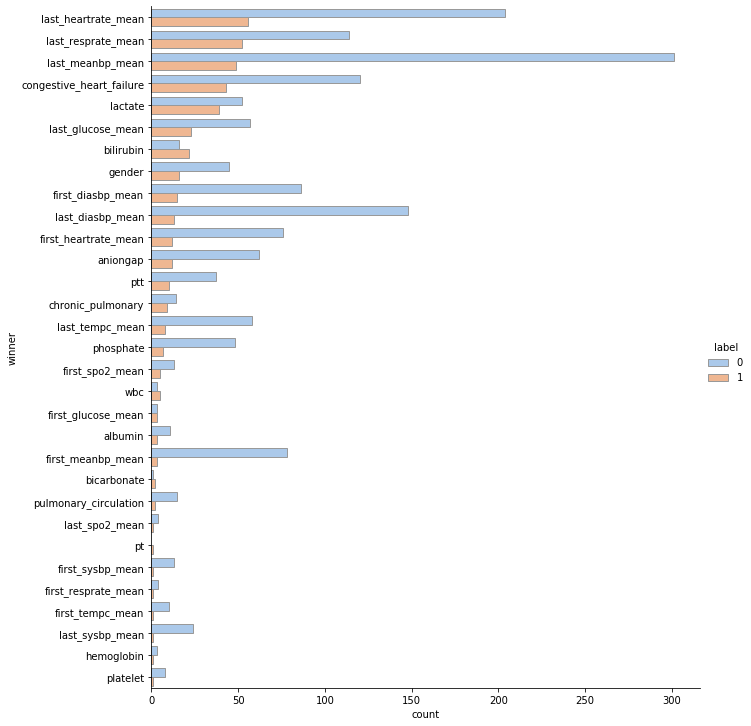

In [30]:
sns.catplot(y="winner", hue="label", kind="count",
            palette="pastel", edgecolor=".6",
            data=consensus, 
            order=order,
            height=10, # make the plot 5 units high
            aspect=1);

In [31]:
explainer = shap.KernelExplainer(sv.predict_proba, shap.kmeans(xst_valid, 100), link="logit")

In [ ]:
shap_values = explainer.shap_values(xst_valid, nsamples=200)

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simp

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!

/Users/ag25710/miniconda3/envs/magec/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning:

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



In [ ]:
shap.summary_plot(shap_values, xst_valid, plot_type="bar")

In [36]:
try:
    import cPickle as pickle
except BaseException:
    import pickle
    
# with open("shap_values", "wb") as f:
#     pickle.dump(shap_values, f)

# with open("shap_explainer", "wb") as f:
#     pickle.dump(explainer, f)
    
# with open("model_svm", "wb") as f:
#     pickle.dump(sv, f)
    
# with open("model_lr", "wb") as f:
#     pickle.dump(lr, f)
    
# with open("model_mlp", "wb") as f:
#     pickle.dump(mlp, f)

In [38]:
# xst_valid.to_csv('xst_valid.csv', index=False)
#Y_valid.to_csv('Y_valid.csv', index=False)

In [ ]:
def shap_save_to_disk(self):
    print("Saving SHAP to .h5 file...")
    h5_file = self.h5_file
    shap_val_df = pd.DataFrame(self.shap_values) #this step is unnecessary, could just save np arrays directly, but the df have some advantages and I don't mind reconverting upon loading
    shap_feat_df = pd.DataFrame(self.features_shap)
    # define what goes in the first row with "d"
    d = [[self.target, self.name_for_figs, self.shap_expected, self.class_thresh]]
    exp_df = pd.DataFrame(
        d, columns=("target", "name_for_figs", "shap_exp_val", "class_thresh")
    )
    shap_val_df.to_hdf(h5_file, key="shap_values", format="table")
    shap_feat_df.to_hdf(h5_file, key="features_shap", format="table")
    exp_df.to_hdf(h5_file, key="shap_expected_value", format="table")

In [ ]:
joined = mg.magec_models(magecs_mlp, magecs_svm, magecs_lr, 
                         Xdata=xst_valid, Ydata=Y_valid['label'], features=feats)

In [ ]:
def most_abnormal(x, features):
    res = None
    feat = None
    for f in features:
        if res is None or abs(x[f]) > res:
            res = abs(x[f])
            feat = f
    return feat

In [ ]:
prob_cols = [c for c in joined.columns if c.startswith('perturb') and '_'.join(c.split('_')[1:-2]) in feats]

In [ ]:
joined['orig_prob_ensemble'] = joined[['orig_prob_mlp', 'orig_prob_lr', 'orig_prob_svm']].apply(np.mean, 1)

In [ ]:
joined[['best_feat', 'new_risk', 'rank_feat', 'rank_val', 'top_rank_prob']] = joined.apply(
    lambda x: mimic.best_feature(x, prob_cols), axis=1)

In [ ]:
joined['most_abnormal'] = joined.apply(lambda x: most_abnormal(x, feats), axis=1)

In [ ]:
joined[['orig_prob_ensemble', 'most_abnormal','best_feat', 'new_risk', 
        'rank_feat', 'rank_val', 'top_rank_prob']].head()

In [ ]:
np.sum(joined['best_feat'] != joined['rank_feat']) / len(joined)

In [ ]:
def expected(x, drivers, sigmas=1, threshold=0.5):
    orig_prob_ensemble = x['orig_prob_ensemble']
    best_feat = x['best_feat']
    rank_feat = x['rank_feat']
    label = x['label']
    # some predicates
    cond1 = orig_prob_ensemble > threshold  # models predict MV (ventilated)
    cond2 = np.all(abs(x[drivers]) <= sigmas)  # all drivers are 'normal'
    cond3 = np.isin(best_feat, drivers) or np.isin(rank_feat, drivers) # MAgEC 'best/ranked feature' is a driver
#     cond4 = x[best_feat] > sigmas # MAgEC 'best feature' is 'abnormal'
    cond5 = label == 1  # patient was ventilated
    # Unexpected (ventilated):
    # 1. ensemble_probability greater than 0.5, 
    # 2. all drivers are normal
    # 3. best feature is not a driver 
    # 4. patient was ventillated
    if cond1 and cond2 and (not cond3) and cond5:
        return 'unexpected_ventilated_nondriver'
    elif cond1 and cond2 and cond3 and cond5:
        return 'unexpected_ventilated_driver'
    # Missed Unexpected (ventilated)
    elif (not cond1) and cond2 and cond5:
        return 'missed_unexpected_ventilated'
    # Expected (ventilated): 
    # 1. one or more drivers were abnormal
    # 2. patient was ventillated
    elif cond1 and (not cond2) and (not cond3) and cond5:
        return 'expected_ventilated_nondriver'
    elif cond1 and (not cond2) and cond3 and cond5:
        return 'expected_ventilated_driver'
    elif (not cond1) and (not cond2) and cond5:
        return 'missed_expected_ventilated'
    # Other (ventilated)
    elif cond5:
        return 'other_ventilated'
    # Unexpected (not ventilated)
    # 1. ensemble_probability less than 0.5
    # 2. one or more drivers are abnormal
    # 3. patient was not ventilated
    elif (not cond1) and (not cond2) and (not cond5):
        return 'unexpected_notventilated'
    # Expected (not ventilated)
    # 1. ensemble_probability less than 0.5
    # 2. all drivers are normal
    # 3. patient was not ventilated
    elif (not cond1) and cond2 and (not cond5):
        return 'expected_notventilated'
    elif cond1 and (not cond5):
        return 'missed_notventilated'
    elif (not cond5):
        return 'other_notventilated'
    else:
        return 'other'

In [ ]:
joined['stats'] = joined.apply(lambda x: expected(x, [d for d in drivers if d.startswith('last')]), axis=1)

In [ ]:
joined['stats'].value_counts()

In [ ]:
excluded = set(df_ml[np.all(np.isnan(df_ml[drivers]), axis=1)].index.values)

In [ ]:
len(excluded), df_cohort.subject_id.nunique()

In [ ]:
filtered = joined[~np.isin(joined.case, list(excluded))]
len(joined), len(filtered)

In [ ]:
filtered['stats'].value_counts().sort_index()

In [ ]:
cols = drivers+['orig_prob_ensemble', 'new_risk', 'most_abnormal','best_feat', 
                'rank_feat', 'rank_val',  'top_rank_prob', 'stats','case']

filtered[filtered['stats'] == 'unexpected_ventilated_nondriver'][cols].head(10)

In [ ]:
filtered[filtered['stats'] == 'unexpected_ventilated_nondriver']['rank_feat'].value_counts()

In [ ]:
filtered[filtered['stats'] == 'unexpected_ventilated_nondriver']['best_feat'].value_counts()

In [ ]:
x1 = filtered[filtered['stats'] == 'unexpected_ventilated_nondriver']['rank_val'].values

In [ ]:
plt.hist(x1, bins=20);

In [ ]:
x2 = filtered[filtered['stats'] == 'expected_ventilated_driver']['rank_val'].values

In [ ]:
plt.hist(x2, bins=20);

In [ ]:
ranks = mg.magec_rank(filtered, rank=len(feats), features=feats, models=('mlp', 'lr', 'svm'))

In [ ]:
ranks.head()

In [ ]:
rbos = mg.magec_rbos(ranks, models=('mlp', 'lr', 'svm'))

In [ ]:
rbos.head()

In [ ]:
rbos['mlp_lr'].mean(), rbos['mlp_lr'].std()

In [ ]:
rbos['svm_lr'].mean(), rbos['svm_lr'].std()

In [ ]:
rbos['svm_mlp'].mean(), rbos['svm_mlp'].std()

In [ ]:
cases = list(filtered[filtered['stats'] == 'unexpected_ventilated_nondriver'].case)

In [ ]:
len(cases)

In [ ]:
cnd0 = np.isin(filtered.case, cases)
cnd1 = np.isin(filtered.case, rbos[rbos['svm_mlp'] > 0.4].case.values)
cnd2 = np.isin(filtered.case, rbos[rbos['svm_lr'] > 0.4].case.values)
cnd3 = np.isin(filtered.case, rbos[rbos['mlp_lr'] > 0.4].case.values)

In [ ]:
len(filtered[cnd0 & cnd1 & cnd2 & cnd3])

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

def bold_column(table):
    for (row, col), cell in table.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    return

def panel_plot(x_train, joined, df_ml, case, timepoint=None,
               models=('lr', 'svm', 'mlp', 'ensemble'), label='label',
               limit=None, rotate=None, save=None, title=None, magec_ensemble=False):

    
    # Grid-Panel
    fig = plt.figure(figsize=(14, 10))
    grid = plt.GridSpec(8, 6, wspace=0.2, hspace=0.1)

    main_fig = fig.add_subplot(grid[0:7, 0:3])
    ml_fig = fig.add_subplot(grid[0:2, 3:])
    bar_fig = fig.add_subplot(grid[2:7, 3:])
    mg_fig = fig.add_subplot(grid[7:, :])
    
    if timepoint is None:
        data = joined.loc[joined.case == case]
    else:
        data = joined.loc[(joined.case == case) & (joined.timepoint == timepoint)]

    case_df = mg.case_stats(data, case, timepoint, models=models)

    ranked = case_df.groupby('feature')['risk_new'].mean().sort_values().index.values
    
    df_ml = df_ml.loc[case]
    
    topK = []
    for r in ranked:
        if not np.isnan(df_ml[r]) and not r.startswith('first'):
            topK.append(r)
            
    if limit:
        topK = topK[:limit]  
    
    collabel0 = ["Case", str(case), "Pop. Mean [SD]"]

    means = x_train.mean()
    stds = x_train.std()
    
    vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']

    labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit

    comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']

    others = ['age', 'gender']
    
    cell_feats = labs + ['last_' + x for x in vitals] + comobs +  others
    
    cell_vals = [round(df_ml[val], 2) for val in cell_feats if not np.isnan(df_ml[val])]
    mean_vals = [str(round(means[val], 1)) + " [" +  str(round(stds[val], 1)) + "]" 
                 for val in cell_feats if not np.isnan(df_ml[val])]
    
    celldata0 = [[x[0], x[1], x[2]] for x in zip(topK, cell_vals,  mean_vals)] + \
        [['True Outcome', data[label].values[0], '']]
    
    case_df = case_df[np.isin(case_df['feature'], topK)]

    base = case_df.groupby('feature')['risk'].mean()

    bar_fig = sns.barplot(x="feature", y="risk_new", data=case_df, ci=None, ax=bar_fig)
    bar_fig.plot(np.linspace(bar_fig.get_xlim()[0], bar_fig.get_xlim()[1], 10),
                 np.mean(base.values) * np.ones(10), '--')
    bar_fig.legend(['current risk', 'estimated risk'], loc='upper right')
    bar_fig.set_ylabel('estimated risk')
    bar_fig.set_ylim([0, min(round(1.2*bar_fig.get_ylim()[1], 1), 1)])
    if rotate is not None:
        bar_fig.set_xticklabels(bar_fig.get_xticklabels(), rotation=rotate)
    bar_fig.set_xlabel('')

        
    collabel1 = ["Model", "Predicted Risk"]

    celldata1 = [[model.upper(), round(data['orig_prob_'+model].values[0], 3)] for model in models]

    collabel2 = ["Model"] + ["MAgEC " + feat for feat in topK]
    celldata2 = list()
 
    
    if not magec_ensemble:
        models = [m for m in models if m != 'ensemble'] 
        
    for model in models:
        add_model = True
        line = list()
        for feat in topK:
            f = model + '_' + feat
            if f not in data:
                add_model = False
                break
            else:
                line.append(round(data[f].values[0], 3))
        if add_model:
            celldata2.append([model.upper()] + line)

            
    main_fig.axis('tight')
    main_fig.axis('off')
    ml_fig.axis('tight')
    ml_fig.axis('off')
    mg_fig.axis('tight')
    mg_fig.axis('off')

    table0 = main_fig.table(cellText=celldata0, colLabels=collabel0, loc='center', cellLoc='center')
    table1 = ml_fig.table(cellText=celldata1, colLabels=collabel1, loc='center', cellLoc='center')
    table2 = mg_fig.table(cellText=celldata2, colLabels=collabel2, loc='center', cellLoc='center')

    table0.set_fontsize(12)
    table0.scale(1.5, 1.5)

    table1.set_fontsize(12)
    table1.scale(1.5, 1.5)

    table2.set_fontsize(12)
    table2.scale(1.5, 1.5)

    table0.auto_set_column_width(col=list(range(len(collabel0))))
    table1.auto_set_column_width(col=list(range(len(collabel1))))
    table2.auto_set_column_width(col=list(range(len(collabel2))))

    bold_column(table0)
    bold_column(table1)
    bold_column(table2)

    if title is not None:
        plt.title(title)

    if save is not None:
        plt.savefig(str(save)+'.png', bbox_inches='tight')

    return fig

In [ ]:
df_notes = mimic.get_cohort_notes()

In [ ]:
filtered[cnd0 & cnd1 & cnd2 & cnd3][cols]

In [ ]:
case = 28974

In [ ]:
mimic.print_notes(df_notes, case)

In [ ]:
panel_plot(x_train, filtered, df_ml, case, limit=6, rotate=25);

In [ ]:
cases = list(filtered[filtered['stats'] == 'unexpected_ventilated_driver'].case)

In [ ]:
cases

In [ ]:
panel_plot(x_train, filtered, df_ml, 29071, limit=6, rotate=25);

In [ ]:
panel_plot(x_train, filtered, df_ml, 31491, limit=6, rotate=25);